# Getting the embeddings

> This notebook gets the embeddings (or latent space) from a multivariate time series 
given by a encoder (e.g., autoencoder).

In [1]:
model_patch_size = 8
verbose          = 0
reset_kernel     = False

In [2]:
from dvats.all import *
from tsai.data.preparation import SlidingWindow
from fastcore.all import *
import wandb
wandb_api = wandb.Api()
from yaml import load, FullLoader
import dvats.utils as ut

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(



Octave is ready <oct2py.core.Oct2Py object at 0x7f421a1ec6d0>

















In [3]:
import torch
torch.cuda.set_device(0)

## Config parameters
> Configuration parameters are obtained from 'config\03-embeddings.yaml'

### Get configuration artifact

In [4]:
config, job_type = get_artifact_config_embeddings(verbose = 0)

In [5]:
dvats.config.show_attrdict(config)

use_wandb: True
wandb_group: embeddings
wandb_entity: mi-santamaria
wandb_project: deepvats
enc_artifact: mi-santamaria/deepvats/mvp:latest
input_ar: None
cpu: False


### Show configuration artifact

In [6]:
for key, value in config.items():
    print(f"{key}: {value}")

use_wandb: True
wandb_group: embeddings
wandb_entity: mi-santamaria
wandb_project: deepvats
enc_artifact: mi-santamaria/deepvats/mvp:latest
input_ar: None
cpu: False


## Build W&B artifact

In [7]:
import os
path = os.path.expanduser("~/work/nbs_pipeline/")
name="03a_embeddings"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
print("runname: "+runname)

runname: 03a_embeddings


In [8]:
run = wandb.init(
    entity      = config.wandb_entity,
    project     = config.wandb_project if config.use_wandb else 'work-nbs', 
    group       = config.wandb_group,
    job_type    = job_type,
    mode        = 'online' if config.use_wandb else 'disabled',
    anonymous   = 'never'  if config.use_wandb else 'must',
    config      = config,
    resume      = 'allow',
    name        = runname
)

wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


## Get trained model artifact

### Build artifact selector
> Botch to use artifacts offline

In [9]:
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

### Get the model from W&B
> Restore the encoder model and its associated configuration

In [10]:
enc_artifact = artifacts_gettr(config.enc_artifact, type='learner')

In [11]:
# TODO: This only works when you run it two timeS! WTF?
try:
    enc_learner = enc_artifact.to_obj()
except:
    enc_learner = enc_artifact.to_obj()

wandb:   1 of 1 files downloaded.  


## Get dataset artifact from W&B
### Restore the dataset artifact used for training the encoder. 
> Even if we do not compute the dimensionality reduction over this dataset, we need to know the metadata of the encoder training set, to check that it matches with the dataset that we want to reduce.

In [12]:
enc_run            = enc_artifact.logged_by()
enc_artifact_train = artifacts_gettr(
                        enc_run.config['train_artifact'], 
                        type='dataset'
                    )
enc_artifact_train.name

'gtrends_khols-normalized_yearly:v0'

In [13]:
dvats.config.show_attrdict(enc_run.config)

r: 0.4
w: 17
MVP: {'r': 0.4, 'lm': 3, 'crit': None, 'sync': False, 'fname': 'encoder_MVP', 'dropout': 0.1, 'verbose': False, 'stateful': False, 'save_best': True, 'nan_to_num': 0, 'custom_mask': None, 'future_mask': True, 'weights_path': None, 'variable_mask': False, 'subsequence_mask': True}
alias: gtrends_khols-normalized_yearly
n_inp: 1
device: cuda
epochs: 200
frozen: False
mvp_ws: [12, 17]
stride: 1
Learner: {'lr': 0.001, 'wd': None, 'arch': 'tsai.models.InceptionTimePlus.InceptionTimePlus', 'moms': [0.95, 0.85, 0.95], 'path': '.', '_name': '<fastai.learner.Learner object at 0x7f811e636110>', 'metrics': None, 'opt_func': 'fastai.optimizer.Adam', 'splitter': 'tsai.models.utils.ts_splitter', 'train_bn': True, 'loss_func': {'axis': -1, '_name': {'axis': -1, '_name': 'FlattenedLoss of MSELoss()', 'is_2d': False, 'flatten': True, 'floatify': True}, 'is_2d': False, 'flatten': True, 'floatify': True}, 'model_dir': 'models', 'wd_bn_bias': False, 'default_cbs': True}
Recorder: {'add_time':

### Specify the dataset artifact that we want to get the embeddings from
> If no artifact is defined, the artifact to reduce will be the one used for validate the encoder.

In [14]:
enc_run.config['batch_size']

16

In [15]:
input_ar_name = ifnone(
    config.input_ar, 
    f'{enc_artifact_train.entity}/{enc_artifact_train.project}/{enc_artifact_train.name}'
)
wandb.config.update({'input_ar': input_ar_name}, allow_val_change=True)
input_ar = artifacts_gettr(input_ar_name)
input_ar.name

'gtrends_khols-normalized_yearly:v0'

In [16]:
df = input_ar.to_df()
df.head()

wandb:   1 of 1 files downloaded.  


,volume
2004-01-01,0.090912
2004-01-08,0.090912
2004-01-15,0.090912
2004-01-22,0.000000
2004-01-29,0.000000


In [17]:
df.shape

(440, 1)

In [18]:
enc_run.config['w'] = 54
enc_run.config['stride'] = 2

In [19]:
enc_input, _ = SlidingWindow(window_len=enc_run.config['w'], 
                             stride=enc_run.config['stride'], 
                             get_y=[])(df)
enc_input.shape

(194, 1, 54)

In [20]:
timer = ut.Time()
timer.start()

1736954549.799509

In [21]:
config.enc_artifact

'mi-santamaria/deepvats/mvp:latest'

In [22]:
print(enc_learner)

In [23]:
enc_learn_class = str(enc_learner.__class__)[8:-2]

match enc_learn_class:
    case "momentfm.models.moment.MOMENTPipeline":
        get_embs_kwargs = {
            "cpu": config.cpu,
            "to_numpy": True,
            "verbose": 1
        }
    case "fastai.learner.Learner":
        get_embs_kwargs = {
            "stride": enc_run.config['stride'],
            "cpu": config.cpu,
            "to_numpy": True,
            "batch_size": enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose": 1
        }
    case "uni2ts.model.moirai.module.MoiraiModule":
        get_embs_kwargs = {
            "cpu": config.cpu,
            "to_numpy": True,
            "batch_size": enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose": 1,
            "patch_size": 8, #Modificar en config (añadir en base.yml & modificar lectura a "si existe, añadir"),
            "size": "small", #Modificar en config (añadir en base.yml & modificar lectura a "si existe, añadir"),
            "time": True
        }
    case _:
        print(f"Model embeddings implementation is not yet implemented for {enc_learn_class}.")

In [24]:
enc_learn_class

'fastai.learner.Learner'

In [25]:
enc_learn_class = str(enc_learner.__class__)[8:-2]
enc_learn_class

'fastai.learner.Learner'

In [26]:
match enc_learn_class:
    case "momentfm.models.moment.MOMENTPipeline":
        get_embs_kwargs = {
            "batch_size": enc_input.shape[0],
            "cpu"       : config.cpu,
            "to_numpy"  : True,
            "verbose"   : 1,
            "padd_step" : 10
        }
    case "fastai.learner.Learner":
        get_embs_kwargs = {
            "stride"         : 1,
            "cpu"            : config.cpu,
            "to_numpy"       : True,
            "batch_size"     : enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose"        : 4
        }
    case "uni2ts.model.moirai.module.MoiraiModule":
        get_embs_kwargs = {
            "cpu"            : config.cpu,
            "to_numpy"       : True,
            "batch_size"     : enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose"        : 2,
            "patch_size"     : model_patch_size, #Modificar en config (añadir en base.yml & modificar lectura a "si existe, añadir"),
            "time"           : True
        }
    case _:
        print(f"Model embeddings implementation is not yet implemented for {enc_learn_class}.")
print(f"Enc learn class {enc_learn_class}\nkwargs: {get_embs_kwargs}")

Enc learn class fastai.learner.Learner
kwargs: {'stride': 1, 'cpu': False, 'to_numpy': True, 'batch_size': 16, 'average_seq_dim': True, 'verbose': 4}


In [27]:
enc_run.config

{'r': 0.4,
 'w': 54,
 'MVP': {'r': 0.4,
  'lm': 3,
  'crit': None,
  'sync': False,
  'fname': 'encoder_MVP',
  'dropout': 0.1,
  'verbose': False,
  'stateful': False,
  'save_best': True,
  'nan_to_num': 0,
  'custom_mask': None,
  'future_mask': True,
  'weights_path': None,
  'variable_mask': False,
  'subsequence_mask': True},
 'alias': 'gtrends_khols-normalized_yearly',
 'n_inp': 1,
 'device': 'cuda',
 'epochs': 200,
 'frozen': False,
 'mvp_ws': [12, 17],
 'stride': 2,
 'Learner': {'lr': 0.001,
  'wd': None,
  'arch': 'tsai.models.InceptionTimePlus.InceptionTimePlus',
  'moms': [0.95, 0.85, 0.95],
  'path': '.',
  '_name': '<fastai.learner.Learner object at 0x7f811e636110>',
  'metrics': None,
  'opt_func': 'fastai.optimizer.Adam',
  'splitter': 'tsai.models.utils.ts_splitter',
  'train_bn': True,
  'loss_func': {'axis': -1,
   '_name': {'axis': -1,
    '_name': 'FlattenedLoss of MSELoss()',
    'is_2d': False,
    'flatten': True,
    'floatify': True},
   'is_2d': False,
   'fl

In [28]:
enc_learner.__class__

fastai.learner.Learner

In [29]:
import warnings
import math
from dvats.memory import *
import dvats.utils as ut
from dvats.config import show_attrdict
from copy import deepcopy
## -- Classes & types
from dataclasses import dataclass, field
from typing import List, Optional, Tuple, Callable, Union, Any

# Fastai
#| export
from fastai.learner import Learner
from tsai.data.core import TSDataLoaders
# Moirai
import uni2ts.model.moirai.module as moirai
import uni2ts.model.moirai.forecast as moirai_forecast

In [30]:
import pandas as pd
import numpy as np
from fastcore.all import *
from tsai.callback.MVP import *
from tsai.imports import *
from tsai.models.InceptionTimePlus import InceptionTimePlus
from tsai.models.explainability import get_acts_and_grads
from tsai.models.layers import *
from tsai.data.validation import combine_split_data
from tsai.basics import *
from fastai.callback.hook import hook_outputs
from momentfm import MOMENTPipeline
from gluonts.dataset.pandas import PandasDataset
from tsai.data.validation import TimeSplitter
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.callback.tracker import SaveModelCallback
import time
import einops
import traceback

In [31]:
#| export
def windowed_dataset(
    X                               : Union [ List [ List [ List [ float ]]], List [ float ], pd.DataFrame ],
    stride                          : int           = 1,
    window_sizes                    : List [int]    = None,
    n_window_sizes                  : int           = 1,
    window_sizes_offset             : int           = 0.05,
    windows_min_distance            : int           = 1,
    full_dataset                    : bool          = False,
    mssg                            : ut.Mssg       = ut.Mssg()
): 
    stride = 1 if stride is None else stride 
    n_window_sizes = 1 if n_window_sizes is None else n_window_sizes
    window_sizes_offset = 0.05 if window_sizes_offset is None else window_sizes_offset
    windows_min_distance = 1 if windows_min_distance is None else windows_min_distance
    full_dataset = False if full_dataset is None else full_dataset
    mssg = ut.Mssg() if mssg is None else mssg

    mssg_ = deepcopy(mssg)
    mssg_.level -= 1
    mssg_.initial(ut.funcname())
    dss = []
    if isinstance(X, list):
        mssg_.print("X is a list. Converting to dataFrame")
        X = np.array(X)
        X = pd.DataFrame(X)        
    if ( isinstance(X,pd.DataFrame) or full_dataset): 
        mssg_.print(f"X is a DataFrame, X~{X.shape} | window_sizes {len(window_sizes) if window_sizes is not None else 0}, n_window_sizes {n_window_sizes}")
        if window_sizes is None or n_window_sizes > len(window_sizes):
            mssg.print("X is a DataFrame | Selecting Fourier's dominant frequences")
            # Select Fourier's dominant frequences
            window_sizes_ = find_dominant_window_sizes_list(
                X               = X, 
                nsizes          = n_window_sizes, 
                offset          = window_sizes_offset, 
                min_distance    = windows_min_distance,
                mssg            = mssg_
            )
            window_sizes = window_sizes_ if window_sizes is None else list(set(window_sizes + window_sizes_))[:n_window_sizes]
            mssg_.print(f"X is a DataFrame | Window sizes: {len(window_sizes)}")
        mssg_.print(f"Building the windows")
        for w in window_sizes:
            mssg_.print(f"w = {w}", verbose_level = mssg_.level+1)
            enc_input, _ = SlidingWindow(window_len = w, stride = stride, get_y=[])(X)
            dss.append(enc_input)
            mssg_.print(f"w {w} | enc_input~{enc_input.shape} | dss~{len(dss)}",  verbose_level = mssg_.level+1)
    else: 
        mssg_.print("X is already windowed")
        dss = [X]
    mssg_.print(f"Number of windows: {len(dss)}")
    mssg_.final()
    return dss


In [32]:
#| export
@dataclass
class EncoderInput:
    # Data
    _data               : Union [ pd.DataFrame, List [ List [ List [ float ]]] ] = None
    _size               : int                               = None
    _shape              : Optional [ Tuple [ int, ... ] ]   = None
    _shapes             : List [ Tuple [ int, ...]]         = None
    stride              : int                               = None
    batch_size          : int                               = None
    _update_size        : bool                              = True
    _update_shape       : bool                              = True
    # Windows                   
    n_windows           : int                               = None
    n_windows_percent   : float                             = None
    validation_percent  : float                             = None
    training_percent    : float                             = None
    window_mask_percent : float                             = None
    # Time                  
    time_flag           : bool                              = None

    def __post_init__(self):
        self._update_size       = True
        self._update_shape      = True
        #Todo: check how to validate the input dataset allowing both windowed or not
        # --- Not working
        ###self._data              = ut._check_value(self.data, None, "_data", pd.DataFrame, allow_none = True )
        ###if self._data is None: 
        ###    self._data = ut._validate_nested_list(self._data, None, "_data", [float, int], 3, False, False, False)
        self.stride,_               = ut._check_value(self.stride, 1, "stride", int, positive = True)
        self.batch_size,_           = ut._check_value(self.batch_size, 32, "batch_size", int,  )
        self.validation_percent,_   = ut._check_value(self.validation_percent, 0.2, "validation_percent", percent = True)
        self.training_percent,_     = ut._check_value(self.training_percent, 0.2, "training_percent", percent = True)
        self.window_mask_percent,_  = ut._check_value(self.window_mask_percent, 0.3, "training_percent", percent = True)
        self.time_flag,_            = ut._check_value(self.time_flag, "time_flag", bool)

    @property
    def size(self):
        if self._data is not None and ( self._update_size or self._size is None or self._size == 0):
            self._size          = len(self._data)
            self._update_size   = False
            self._size,_ = ut._check_value(self._size, 0, "_size", int)
            self._size = max(self._size, 0)
        elif self._update_size: 
            self._size = 0
            self._update_size = True
        return self._size
    
    @property
    def shape(self) -> Tuple[int, ...]:
        if (
                self._data is not None and 
                ( self._update_shape or self._shape is None or self._shape == 0 )
        ):
            try: 
                self._shape     = self._data.shape
                self._shapes    = [ self._shape ]
            except:
                self._shape  = self._data[0].shape
                self._shapes = [ self._data[i].shape for i in range(len(self._data))]
            self._update_shape = False
        elif self._update_shape: 
            self._shape = 0,
            self._shapes = []
            self._update_shape = True
        return self._shape
    @property
    def shapes(self) -> List [ Tuple [ int, ... ]]:
        if (
            self._data is not None and 
            ( self._update_shape or self._shapes is None or self._shapes ==[])
        ):
            try: 
                self._shape     = self._data.shape
                self._shapes    = [ self._shape ]
            except:
                self._shape     = self._data[0].shape
                self._shapes    = [ self._data[i].shape for i in range(len(self._data))]
            self._update_shape  = False
        elif self._update_shape: 
            self._shape         = 0,
            self._shapes        = []
            self._update_shape  = True
        return self._shapes
            
    @property
    def data(self):
        return self._data
    
    @data.setter
    def data(self, value):
        self._data          = value
        self._update_size   = True
        self._update_shape  = True
@dataclass
class LRScheduler:
    lr              : float = None
    flag            : bool  = None
    name            : str   = None
    num_warmup_steps: int   = None

    def __post_init__(self):
        self.lr                 = self._check_lr(self.lr, 1e-5)
        self.flag               = self._check_flag(self.flag, False)
        self.name               = self._check_name(self.name, "OneCycleR")
        self.num_warmup_steps   = self._check_steps(self.num_warmup_steps, 0)

    # Validation methods
    def _check_lr(self, value, default):
        if not isinstance(value, (float, int)) or not math.isfinite(value) or value <= 0:
            warnings.warn(f"Invalid learning rate 'lr' ({value}). Using default: {default}")
            return default
        return float(value)

    def _check_flag(self, value, default):
        if not isinstance(value, bool):
            warnings.warn(f"Invalid type for 'flag' ({type(value)}). Using default: {default}")
            return default
        return value

    def _check_name(self, value, default):
        if not isinstance(value, str):
            warnings.warn(f"Invalid type for 'name' ({type(value)}). Using default: {default}")
            return default
        return value

    def _check_steps(self, value, default):
        if not isinstance(value, int) or value < 0:
            warnings.warn(f"Invalid type or negative value for 'num_warmup_steps' ({value}). Using default: {default}")
            return default
        return value
@dataclass
class EncoderOptimizer():
    criterion   : Optional   [ torch.nn.Module ]          = torch.nn.MSELoss
    optimizer   : Optional   [ torch.optim.Optimizer ]    = None
    lr          : Union      [ float, LRScheduler ]       = 1e-5

    def _post__init__(self):
        self.lr,_ = ut._check_value( self.lr, 1e-5, "lr", [ int, float ], False, True, False )    
#| export
@dataclass
class Encoder():
    model               : Tuple [ 
                            MOMENTPipeline,
                            Learner,
                            moirai.MoiraiModule
                        ]                   = None
    input               : EncoderInput      = EncoderInput()
    mssg                : ut.Mssg           = ut.Mssg()
    cpu                 : bool              = False
    to_numpy            : bool              = False
    num_epochs          : int               = 1
    optim               : EncoderOptimizer  = EncoderOptimizer()
    mask_stateful       : bool              = False
    mask_future         : bool              = False
    mask_sync           : bool              = False
    eval_stats_pre      : AttrDict          = None
    eval_stats_post     : AttrDict          = None
    use_moment_masks    : bool              = False
    model_class         : str               = None
    time_flag           : bool              = False
    use_wandb           : bool              = False
    analysis_mode       : str               = 'online'
    splits              : Tuple             = None
    show_plot           : bool              = False
    norm_by_sample      : bool              = True
    norm_use_single_batch : bool            = True
    
    #mvp_ws              : Tuple [ int, int ]= 0,0
    def __post_init__(self):
        self.model          , _ = ut._check_value(self.model, None, "model", [ MOMENTPipeline, Learner, moirai.MoiraiModule ], True, False, False, mssg = self.mssg)
        self.model              = self.set_model_(self.model)
        ## TODO: check how to do this check
        #self.input          , _ = ut._check_value(self.input, EncoderInput(), "input", EncoderInput, True)
        self.mssg           , _ = ut._check_value(self.mssg, ut.Mssg(), "mssg", ut.Mssg, mssg = self.mssg)
        self.cpu            , _ = ut._check_value(self.cpu, False, "cpu", bool, mssg = self.mssg)
        self.to_numpy       , _ = ut._check_value(self.to_numpy, False, "to_numpy", bool,  mssg = self.mssg)
        self.num_epochs     , _ = ut._check_value(self.num_epochs, 1, "num_epochs", int, False, True,  mssg = self.mssg)
        ## TODO: check how to do this check
        #self.optim          , _ = ut._check_value(self.optim, EncoderOptimizer(), "optim", EncoderOptimizer)
        self.mask_stateful  , _ = ut._check_value(self.mask_stateful, False, "mask_statefull", bool,  mssg = self.mssg)
        self.mask_future    , _ = ut._check_value(self.mask_future, False, "mask_future", bool,  mssg = self.mssg)
        self.mask_sync      , _ = ut._check_value(self.mask_sync, False, "mask_sync", bool,  mssg = self.mssg)
        self.eval_stats_pre , _ = ut._check_value(self.eval_stats_pre, None, "eval_stats_pre", AttrDict, True,  mssg = self.mssg)
        self.eval_stats_post, _ = ut._check_value(self.eval_stats_post, None, "eval_stats_post", AttrDict, True,  mssg = self.mssg)
        self.use_moment_masks, _= ut._check_value(self.use_moment_masks, False, "use_moment_masks", bool,  mssg = self.mssg)
        self.model_class        = None # Must be computed through get_model_class to avoid errors
        self.time_flag      , _ = ut._check_value(self.time_flag, False, "time_flag", bool,  mssg = self.mssg)
        self.show_plot      , _ = ut._check_value(self.show_plot, False, "show_plot", bool, mssg = self.mssg)
    
    def print(self, **kwargs):
        self.mssg.print(**kwargs)

    def get_model_class(self, force : bool = False): 
        if force or self.model_class is None:
            self.model_class = str(self.model.__class__)[8:-2]
        return self.model_class
    def set_model_(self, model):
        if model is not None:
            self.model          = model
            self.model_class    = self.get_model_class() 
            try: # Initially it may not be defined and that would result in an execution error
                self.fine_tune_     = self.set_fine_tune_()
            except:
                self.fine_tune_ = None
        return self.model
    
    def get_splits_(self, n_sample: int = None):
        self.mssg.initial_(ut.funcname())
        #TODO: add checks for datatype to ensure the dataset is not already windowed
        assert self.analysis_mode in [ 'ofline', 'online'], 'Invalid analysis mode'
        X = self.input.data if n_sample is None else self.input.data[n_sample]
        self.mssg.print(f"len(X)={len(X)}")
        match self.analysis_mode:
            case 'online':
                self.mssg.print("Online analysis", verbose_level = self.mssg.level+1)
                self.splits = TimeSplitter(valid_size = 0.2, show_plot = self.show_plot)(X)
            case 'offline':
                self.mssg.print("Offline analysis", verbose_level = self.mssg.level+1)
                self.splits = get_splits(np.arange(len(X)), valid_size=self.valid_size, show_plot = self.show_plot)
            case _:
                raise NotImplementedError(f"Encoderl{ut.funcname()} | Case {self.analysis_mode} not implemented. Use one of the following options: <online|offline>.")
        self.mssg.print(f"X~{X.shape}")
        self.mssg.print(f"Train: {len(self.splits[0])} | Test { len(self.splits[1])}")
        self.mssg.final()
        return X

    #TODO: poner los equivalentes para train, eval, get_embeddings, get_acts, etc.
    
    # Fine_tune_single_
    def fine_tune_moment_single_(self):
        raise NotImplementedError(f"Encoder.{ut.funcname()} not yet implemented")
    def fine_tune_mvp_single_(self):
        raise NotImplementedError(f"Encoder.{ut.funcname()} not yet implemented")
    def fine_tune_moirai_single_(self):
        raise NotImplementedError(f"Encoder.{ut.funcname()} not yet implemented")
    def fine_tune_single_(self):
        raise NotImplementedError(f"Encoder.{ut.funcname()} not yet implemented")

    # Fine_tune_
    def fine_tune_moment_(self, eval_pre = False, eval_post = False, shot = True, time_flag = False, use_moment_masks = False): 
        raise NotImplementedError(f"Encoder.{ut.funcname()} not yet implemented")
    def fine_tune_mvp_(self, eval_pre = False, eval_post = False, shot = True, time_flag = False): 
        raise NotImplementedError(f"Encoder.{ut.funcname()} not yet implemented")
    def fine_tune_moirai_(self, eval_pre = False, eval_post = False, shot = True, time_flag = False): 
        raise NotImplementedError(f"Encoder.{ut.funcname()} not yet implemented")
    def fine_tune_(self, eval_pre = False, eval_post = False, shot = True, time_flag = False):
        raise NotImplementedError(f"Encoder.{ut.funcname()} not yet implemented")
    def set_fine_tune_(self):
        raise NotImplementedError(f"Encoder.{ut.funcname()} not yet implemented")
    def show_eval_stats(self):
        raise NotImplementedError(f"Encoder.{ut.funcname()} not yet implemented")

In [33]:
#| export
def set_fine_tune_single_(
    self: Encoder
) -> Callable:
    self.mssg.initial_(ut.funcname())
    model_class = self.get_model_class()
    self.mssg.print(f"Model class: {model_class}")
    match model_class:
        case "momentfm.models.moment.MOMENTPipeline":
            self.fine_tune_single_ = self.fine_tune_moment_single_
        case "fastai.learner.Learner":
            self.fine_tune_single_ = self.fine_tune_mvp_single_
        case "uni2ts.model.moirai.module.MoiraiModule":
            self.fine_tune_single_ = self.fine_tune_moirai_single_
        case _:
            self.mssg.print(f"Fine-tune single shot implementation is not yet implemented for {self.model_class}.", verbose_level = self.mssg.level+1)
            raise NotImplementedError(f"fine_tune_single_ | Not yet implemented for {self.model_class}")
    self.mssg.final(ut.funcname())
    return(self.fine_tune_single_)
Encoder.set_fine_tune_single_ = set_fine_tune_single_

In [34]:
#| export
def set_fine_tune_(
    self: Encoder
) -> Callable:
    self.mssg.initial_("set_fine_tune_")
    model_class = self.get_model_class()
    self.mssg.print(f"Model class: {model_class}")
    match model_class:
        case "momentfm.models.moment.MOMENTPipeline":
            self.mssg.print(f"Moment")
            self.fine_tune_ = self.fine_tune_moment_
        case "fastai.learner.Learner":
            self.mssg.print(f"MVP")
            self.fine_tune_ = self.fine_tune_mvp_
        case "uni2ts.model.moirai.module.MoiraiModule":
            self.mssg.print(f"Moirai")
            self.fine_tune_ = self.fine_tune_moirai_
        case _:
            self.mssg.print(f"Fine-tune implementation is not yet implemented for {self.model_class}.", verbose_level = self.mssg.level+1)
            raise NotImplementedError(f"fine_tune | Not yet implemented for {self.model_class}")
    self.mssg.final(ut.funcname())
    return(self.fine_tune_)
Encoder.set_fine_tune_ = set_fine_tune_

In [35]:
#| export
from fastai.metrics import mae
def rmse(preds, targets):
    print("--> rmse")
    res = torch.sqrt(torch.nn.functional.mse_loss(preds, targets))
    print("rmses -->")
    return res

def smape(preds, targets):
    print("--> smape")
    res = 100 * torch.mean(2 * torch.abs(preds - targets) / (torch.abs(preds) + torch.abs(targets)))
    print("smape -->")
    return res


In [36]:
#| export
def show_eval_stats(
    self            : Encoder, 
    print_to_path   : bool      = None, 
    print_path      : str       = None, 
    print_mode      : str       = None,
    eval_pre        : bool = False,
    eval_post       : bool = False,
    eval_stats_pre  : AttrDict = None,
    eval_stats_post : AttrDict = None,
    func_name       : str = ""
):
    self.mssg.print(f"{func_name} | Evaluation summary")
    self.eval_stats_pre = self.eval_stats_pre if eval_stats_pre is None else eval_stats_pre
    self.eval_stats_post = self.eval_stats_post if eval_stats_post is None else eval_stats_post
    self.mssg.to_path = self.mssg.to_path if print_to_path is None else print_to_path
    self.mssg.path = self.mssg.path if print_path is None else print_path
    self.mssg.mode = self.mssg.mode if print_mode is None else print_mode        
    if (eval_pre):
        self.mssg.print(f"Eval pre: ")
        show_attrdict(
            self.eval_stats_pre,
            print_to_path   = self.mssg.to_path,
            print_path      = self.mssg.path,
            print_mode      = self.mssg.mode
        )
    if eval_post:
        self.mssg.print(f"Eval post: ")
        show_attrdict(
            self.eval_stats_post,
            print_to_path   = self.mssg.to_path,
            print_path      = self.mssg.path,
            print_mode      = self.mssg.mode 
        )
Encoder.show_eval_stats = show_eval_stats

In [37]:
#| export
#TODO: Check. Adding lr_scheduler & optimizer to mvp
from fastai.callback.core import Callback

class CustomOptimizerCallback(Callback):
    def __init__(self, optimizer, scheduler):
        self.optimizer = optimizer
        self.scheduler = scheduler

    def before_fit(self):
        # Reemplazar el optimizador de FastAI con el personalizado
        self.learn.opt = self.optimizer

    def after_batch(self):
        # Actualizar el scheduler después de cada batch
        if self.scheduler is not None:
            self.scheduler.step()

    def after_fit(self):
        # Restaurar el optimizador original si es necesario
        del self.learn.opt

In [38]:
from fastai.losses import MSELossFlat

In [39]:
from fastai.callback.core import Callback

In [40]:
class CustomMetricCallback(Callback):
    "Setting up a callback to get loss metrics different to those defined in learner.crit"
    def __init__(self, metric_func = MSELossFlat,  metric_name : str = None):
        self.metric_name  = metric_name if metric_name is not None else metric_func.__name__
        self.metric_func  = metric_func
        self.metric_value = None
    def before_validate(self):
        self.metric_value = 0
        self.count = 0
    def after_pred(self):
        preds   = self.learn.pred
        targets = self.learn.y
        self.metric_value += self.metric_func(preds, targets)
        self.count += 1
    def after_validate(self):
        self.metric_value /= self.count
        print(f'{self.metric_name}: {self.metric_value}')

In [41]:
class MVPMetricsRecorder(MVP):
    """
    Callback to record custom metric values during validation.
    Stores the results in a shared dictionary for later use.
    """
    def __init__(self, metrics_dict, eval_results_pre, eval_results_post, validate_before_train, validate_after_train, **args):
        self.metrics_dict          = metrics_dict
        self.eval_results_pre      = eval_results_pre
        self.eval_results_post     = eval_results_post
        self.validate_before_train = validate_before_train
        self.validate_after_train  = validate_after_train
        self.current_results       = None
        super().__init__(**args)
    
    def red_print(self, mssg, header = ""):
            print(f"\033[91m{header} | {mssg} \033[0m")

    def before_fit(self): 
        try:
            if self.validate_before_train:
                self.red_print("--> Before fit | Exec validate", "MVP")
                print("Assign current result")
                self.current_results = self.eval_results_pre #Assigns pointer
                self.red_print("Before fit | Exec validate -->", "MVP")
        except Exception as e:
            print(f"Error in MVPMetricsRecorder | Before Fit: {e}")
            raise
        super().before_fit()
    
    def after_fit(self): 
        try:
            if self.validate_after_train:
                self.red_print("--> After fit | Exec validate", "MVP")
                self.current_results = self.eval_results_post #Assigns pointer
                self.red_print("After fit | Exec validate -->", "MVP")
        except Exception as e:
            print(f"Error in MVPMetricsRecorder | After Fit: {e}")
            raise
        super().after_fit()
        
    def before_validate(self):
        print("Before validate")
        try:
            self.red_print("Before validate: Reset dictionary", "MVP")
            # Reset the metric dictionary for the current validation pass
            for metric_name, _ in self.current_results.items():
                self.current_results[metric_name] = []
        except Exception as e:
            print(f"Error in MVPMetricsRecorder | Before Validate: {e}")
            raise
            
    def after_pred(self):
        try:
            self.red_print("after_pred | Calculate and store each metric for the current batch", "MVP")
            # Calculate and store each metric for the current batch
            preds = self.learn.pred
            targets = self.learn.y
            for metric_name, metric_func in self.metrics_dict.items():
                try:
                    batch_value = metric_func(
                        preds[self.mask], 
                        targets[self.mask]
                    ).item()
                    self.red_print(f"Batch value: {batch_value}", "MVP")
                except Exception as e:
                    self.red_print(f"Error computing {metric_name} ({metric_func.__name__}): {e}", "MVP")
        except Exception as e:
            print(f"Error in MVPMetricsRecorder | After pred: {e}")
            raise
            self.current_results[metric_name] += [ batch_value ]
    
    def after_validate(self):
        try:
            # Aggregate results for all batches in validation
            for metric_name, values in self.metrics_dict.items():
                self.current_results[metric_name] = sum(values) / len(values)
            self.red_print(f"MVP | Validation results: {self.current_results}")
        except Exception as e:
            print(f"Error in MVPMetricsRecorder | After validate: {e}")
            raise


In [42]:
class CustomWandbCallback(WandbCallback):
    """
    Callback that extends WandbCallback to avoid errors when validation 
    is done before training.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def before_fit(self):
        """
        Overrides before_fit to ensure that'epoch' key exists.
        """
        try:
            if wandb.run is not None and wandb.run.step:
                if 'epoch' not in wandb.run.summary._as_dict():
                    wandb.run.summary.update({'epoch': 0})
        except Exception as e:
            print(f"Error while checking epoch in wandb: {e}")
            raise 
        super().before_fit() # Call the original method 

In [58]:
#| export
def validate_with_metrics_(learner, metrics):
    results = []
    for metric in metrics:
        learner.crit = metric
        result = learner.validate()
        results.append(result.item() if hasattr(result, 'item') else result)
    learner.crit=MSELossFlat
    return results
    
def validate_with_metrics(learner, metrics):
    results = []
    learner_ = deepcopy(learner)
    for metric in metrics:
        learner_.crit = metric
        result = learner_.validate()
        result = result.item() if hasattr(result, 'item') else result
        results.append(result)
        print(f"validate_with_metrics | {metric} | {result}")
    learner.crit=MSELossFlat
    return results
    

def get_metrics_dict(
    metrics: List[Callable],
    metrics_names: List[str] = None
) -> Dict[str, Callable]:
    """
    Creates a dictionary mapping metric names to metric functions.

    Args:
        metrics (List[Callable]): A list of metric functions.
        metrics_names (List[str], optional): A list of metric names corresponding to the functions.

    Returns:
        Dict[str, Callable]: A dictionary mapping metric names to their corresponding functions.
    """
    if metrics_names is None:
        # Use the function's name as the key if names are not provided
        metrics_dict = {metric.__name__: metric for metric in metrics}
    elif len(metrics) == len(metrics_names):
        # Use provided names if lengths match
        metrics_dict = {name: metric for name, metric in zip(metrics_names, metrics)}
    else:
        raise ValueError("Length of metrics and metrics_names must match when metrics_names is provided.")
    
    return metrics_dict

def fine_tune_mvp_single_(
    self            : Encoder,
    eval_pre        : bool  = False,
    eval_post       : bool  = False,
    shot            : bool  = False,
    show_plot       : bool  = False,
    sample_id       : int   = 0    
):
    self.show_plot = self.show_plot if show_plot is None else show_plot
    t_shot = 0
    t_eval_1 = 0
    t_eval_2 = 0
    losses = [],
    metrics = [ MSELossFlat, RMSELossFlat, MAELossFlat, SMAPELossFlat ]
    metrics_dict = get_metrics_dict(metrics, ["mse", "rmse", "mae", "smape"])
    eval_results_pre = {key: 0.0 for key in metrics_dict.keys()}
    eval_results_post = {key: 0.0 for key in metrics_dict.keys()}
    
    if self.time_flag : timer = ut.Time(mssg = self.mssg)
    self.mssg.initial("fine_tune_mvp_single_")   
    X = self.get_splits_(sample_id)
    self.mssg.print("About to set callbacks", func_name = ut.funcname())
    
    cbs = L(CustomWandbCallback(log_preds=False)) if self.use_wandb else L()
    
    
    cbs2 = [
        EarlyStoppingCallback(
            monitor='valid_loss', 
            min_delta=0.000001, 
            patience=10
        )
        #SaveModelCallback(
        #    monitor = 'valid_loss', 
        #    fname = 'best_model'
        #),
    ]
    

    self.mssg.print("About to set batch tfms")
    tfms = [ToFloat(), None]
    batch_tfms = [
        TSStandardize(
            by_sample       = self.norm_by_sample, 
            use_single_batch= self.norm_use_single_batch
        )
    ]
    dls = get_ts_dls(X, splits = self.splits, tfms = tfms, bs = self.input.batch_size, batch_tfms = batch_tfms)

    ### 
    # Optimizer  ### TODO: CHECK
    #### if not ( isinstance(self.optim.lr, float) or isinstance(self.optim.lr, int)):
    ####     if self.optim.lr.flag:
    ####         scheduler = setup_scheduler(
    ####             dl_train = dls.train,
    ####             lr_scheduler_flag = True,
    ####             lr_scheduler_name = self.optim.lr.name,
    ####             optimizer         = self.optim.optimizer,
    ####             num_epochs        = self.num_epochs,
    ####             lr_scheduler_num_warmup_steps = self.optim.lr.num_warmup_steps,
    ####             lr_scheduler_max_lr = None, #TODO: Think
    ####             lr                  = self.optim.lr.lr
    ####         )
    ####         custom_opt_cb = CustomOptimizerCallback(optimizer = self.optim.optimizer, scheduler = scheduler)
    ####         cbs2 += [custom_opt_cb]
    ###
    
    
    self.mssg.print(f"Metrics: {metrics}")
    if self.show_plot: 
        self.mssg.print("Show plot")
        display(dls.show_at(0))
        sgc = ShowGraphCallback2()
        self.model = ts_learner(
            dls, 
            InceptionTimePlus,
            cbs = cbs + sgc +MVP(
                r           = self.optim.lr if isinstance(self.optim.lr, float) else self.optim.lr.lr,
                window_size = X.shape[2]-1,
                future_mask = self.mask_future,
                target_dir  = './models',
                sync        = self.mask_sync,
                stateful    = self.mask_stateful,
                fname       = f'encoder_MVP',
                #metrics_dict      = metrics_dict,
                #eval_results_pre  = eval_results_pre,
                #eval_results_post = eval_results_post,
                #validate_before_train = eval_pre,
                #validate_after_train  = eval_post
            ),
            y_range = [X.min(), X.max()]#,
            #metrics = metrics
        )
    else:
        self.mssg.print("Don't show plot")
        self.model = ts_learner(
            dls, 
            InceptionTimePlus,
            cbs = cbs + mvp(
                r           = self.optim.lr if ( isinstance(self.optim.lr, float) or isinstance(self.optim.lr, int)) else self.optim.lr.lr,
                window_size = X.shape[2]-1,
                future_mask = self.mask_future,
                target_dir  = './models',
                sync        = self.mask_sync,
                stateful    = self.mask_stateful,
                fname       = f'encoder_MVP',
                #metrics_dict      = metrics_dict,
                #eval_results_pre  = eval_results_pre,
                #eval_results_post = eval_results_post,
                #eval_pre          = eval_pre,
                #eval_post         = eval_post
            ),
            y_range = [X.min(), X.max()]#,
            #metrics = metrics
        )
        self.mssg.print(f"Model Class {self.model.__class__} | Type: {type(self.model)}")

    device = "cpu" if self.cpu else torch.cuda.current_device()
    self.model.to(device)
    self.mssg.print(f"Model Class {self.model.__class__} | Type: {type(self.model)}")
    
    # Eval - pre 
    if eval_pre:
        if self.time_flag: timer.start()
        self.mssg.print(f"Eval Pre | wlen {X.shape[2]} | Model: {self.model.__class__} | {type(self.model)} ")
        self.mssg.print(f"Model metrics: {self.model.metrics}")
        self.model.eval()
        #self.mssg.print(f"Model metrics after eval: {self.model.metrics}")
        results = validate_with_metrics(self.model, metrics)
        #self.model.validate()
        #self.mssg.print(f"Model metrics after validate: {self.model.metrics}")
        self.mssg.print(f"results~{len(results)}")
        eval_results_pre = mvp_format_results(results)
        self.mssg.print(f"Eval results pre with custom metrics: {eval_results_pre}")
        if self.time_flag:
            timer.end()
            t_eval_1 = timer.duration()
            timer.show(verbose = self.mssg.verbose)
    # Train 
    if shot:
        if self.time_flag: timer.start()
        self.model.train()
        self.mssg.print(f"Training the model | window size {X.shape[2]} | X ~ {X.shape}")
        lr_valley, lr_steep = self.model.lr_find(suggest_funcs=(valley, steep), show_plot=show_plot)
        self.model.fit_one_cycle(
            n_epoch = self.num_epochs, 
            lr_max  = lr_valley,  
            cbs     = cbs2
        )
        losses = self.model.recorder.losses
        if self.time_flag:
            timer.end()
            t_shot= timer.duration()
            timer.show(verbose = self.mssg.verbose)

    # Eval - post
    if eval_post:
        if self.time_flag: timer.start()
        self.mssg.print(f"Eval Pre | wlen {X.shape[2]}")
        self.model.eval()
        results = validate_with_metrics(self.model, metrics)
        self.mssg.print(f"Format results | results~{len(results)}")
        eval_results_post = mvp_format_results(results)
        #self.model.validate()
        self.mssg.print(f"Eval results post with custom metrics: {eval_results_post}")
        if self.time_flag:
            timer.end()
            t_eval_2 = timer.duration()
            timer.show(verbose = self.mssg.verbose)
    self.mssg.final()
    return losses, eval_results_pre, eval_results_post, t_shot, t_eval_1, t_eval_2, self.model
Encoder.fine_tune_mvp_single_ = fine_tune_mvp_single_

In [44]:
#| export
# TODO: Revisar inclusion del optimizer en fine_tune_mvp_
def mvp_format_results(results):
    return {
        "mse":  results[0],
        "rmse": results[1],
        "mae":  results[2],
        "smape":results[3]
    }

def fine_tune_mvp_(
    self                    : Encoder,
    eval_pre                : bool  = True,
    eval_post               : bool  = True,
    shot                    : bool  = False,
    time_flag               : bool  = None,
    use_wandb               : bool  = None,
    analysis_mode           : str   = None,
    norm_by_sample          : bool  = None,
    norm_use_single_batch   : bool  = None,
    show_plot               : bool  = None
):
    self.mssg.initial_("fine_tune_mvp_")
    self.time_flag      = self.time_flag if time_flag is None else time_flag
    self.use_wandb      = self.use_wandb if use_wandb is None else use_wandb
    self.analysis_mode  = self.analysis_mode if analysis_mode is None else analysis_mode
    self.norm_by_sample = self.norm_by_sample if norm_by_sample is None else norm_by_sample
    self.norm_use_single_batch = self.norm_use_single_batch if norm_use_single_batch is None else norm_use_single_batch
    
    self.mssg.print(f"time_flag: {self.time_flag}")
    # Return values
    lossess             = []
    eval_results_pre    = []
    eval_results_post   = []
    t_shots             = []
    t_shot              = 0
    t_evals             = []
    t_eval              = 0

    if self.input.size is None:
        self.mssg.print(f"Windows: {len(self.input._data)}")
        raise ValueError(f"Invalid number of windows: {self.input.size}")
    self.mssg.print(f"Processing {self.input.size} datasets: {self.input.shapes}")
    # Build optimizer
    if self.optim.optimizer is None: 
        self.mssg.print(f"Setting up optimizer as AdamW")
        if (not isinstance(self.optim.lr, float)):
            self.optim.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.optim.lr.lr)
        else:
            self.optim.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.optim.lr)
    # Compute model for each window in the windowed dataset
    for i in range(self.input.size):
        self.mssg.print(f"Processing wlen {self.input.shape[2]}")
        ( 
            losses, eval_results_pre_, eval_results_post_, t_shot_, t_eval_1, t_eval_2, self.model
        ) =  self.fine_tune_mvp_single_(eval_pre, eval_post, shot, sample_id = i, show_plot = show_plot)
        lossess.append(losses)
        if (eval_pre): eval_results_pre = eval_results_pre_
        eval_results_post.append(eval_results_post_)
        print("t_shot_:", t_shot_)
        t_shots.append(t_shot_)
        if eval_pre: t_evals.append(t_eval_1)
        if eval_post: t_evals.append(t_eval_2)
        eval_pre = False
    t_shot = sum(t_shots)
    t_eval = sum(t_evals)
    self.mssg.final(ut.funcname())
    return lossess, eval_results_pre, eval_results_post, t_shots, t_shot, t_evals, t_eval, self.model

Encoder.fine_tune_mvp_ = fine_tune_mvp_

In [45]:
#| export
from tqdm.auto import tqdm
from transformers import get_scheduler
import evaluate
from torch.nn.modules.loss import _Loss
from tsai.data.preparation import SlidingWindow
from dvats.utils import find_dominant_window_sizes_list

In [46]:
#| export
def _get_mssg(
    mssg : ut.Mssg = None,
    verbose                         : int           = 0, 
    print_to_path                   : bool          = False,
    print_path                      : str           = "~/data/logs/logs.txt",
    print_mode                      : str           = 'a',
):
    mssg,_ = ut._check_value(mssg, None, "mssg", ut.Mssg)
    if mssg is None:
        mssg = ut.Mssg(
            to_path = print_to_path,
            path    = print_path,
            mode    = print_mode,
            level   = 0,
            verbose = verbose
        ) 
    return mssg

def _get_enc_input(
    mssg                            : ut.Mssg,
    # Encoder Input
    ## -- Using all parammeters
    X                               : Optional [ Union [ List [ List [ List [ float ]]], List [ float ], pd.DataFrame ] ],
    stride                          : Optional [ int ]          = None,
    batch_size                      : Optional [ int ]          = None,
    n_windows                       : Optional [ int ]          = None,
    n_windows_percent               : Optional [ float ]        = None,
    validation_percent              : Optional [ float ]        = None, 
    training_percent                : Optional [ float ]        = None,
    window_mask_percent             : Optional [ float ]        = None,
    window_sizes                    : Optional [ List [int] ]   = None,
    n_window_sizes                  : Optional [ int ]          = 1,
    window_sizes_offset             : Optional [ int ]          = 0.05,
    windows_min_distance            : Optional [ int ]          = 1,
    full_dataset                    : Optional [ bool ]         = False,
    ## -- Using Type
    enc_input                       : Optional [ EncoderInput ] = None
): 
    mssg.initial_(func_name = ut.funcname())
    enc_input, _ = ut._check_value(enc_input, None, "enc_input", EncoderInput, True, False, False)
    mssg.print(f"is none enc_input? {enc_input is None}")
    if enc_input is None:
        mssg.print(f"About to get the windows")
        enc_input = windowed_dataset(
            X                       = X,
            stride                  = stride,
            window_sizes            = window_sizes,
            n_window_sizes          = n_window_sizes,
            window_sizes_offset     = window_sizes_offset,
            windows_min_distance    = windows_min_distance,
            full_dataset            = full_dataset,
            mssg                    = mssg
        )
        mssg.print(f"About to get the encoder input | windows~{len(enc_input)}")
        enc_input = EncoderInput(
            _data               = enc_input, 
            stride              = stride,
            batch_size          = batch_size,
            n_windows           = n_windows,
            n_windows_percent   = n_windows_percent,
            validation_percent  = validation_percent,
            training_percent    = training_percent,
            window_mask_percent = window_mask_percent,
        )
        mssg.print(f"Enc input obtained | enc_input~{enc_input.shape}")
    mssg.final()
    return enc_input

def _get_optimizer(
    mssg                            : ut.Mssg,
    optim                           : EncoderOptimizer = None,
    criterion                       : _Loss         = torch.nn.MSELoss, 
    optimizer                                       = None, 
    lr                              : float         = 5e-5, #1e-4, 
    lr_scheduler_flag               : bool          = False, 
    lr_scheduler_name               : str           = "linear",
    lr_scheduler_num_warmup_steps   : int           = None
):
    mssg.initial(ut.funcname())
    optim,_ = ut._check_value(optim, None, "optim", EncoderOptimizer, True)
    if optim is None:
        optim = EncoderOptimizer(
            criterion   = criterion,
            optimizer   = optimizer,
            lr          = LRScheduler (
                            lr              = lr,
                            flag            = lr_scheduler_flag,
                            name            = lr_scheduler_name,
                            num_warmup_steps= lr_scheduler_num_warmup_steps
            ),
        )
    mssg.final()
    return optim

def _get_encoder(
    ## -- Using all parammeters
    X                               : Optional [ Union [ List [ List [ List [ float ]]], List [ float ], pd.DataFrame ] ],
    stride                          : Optional [ int ]          = None,
    batch_size                      : Optional [ int ]          = None,
    n_windows                       : Optional [ int ]          = None,
    n_windows_percent               : Optional [ float ]        = None,
    validation_percent              : Optional [ float ]        = None, 
    training_percent                : Optional [ float ]        = None,
    window_mask_percent             : Optional [ float ]        = None,
    window_sizes                    : Optional [ List [int] ]   = None,
    n_window_sizes                  : Optional [ int ]          = 1,
    window_sizes_offset             : Optional [ int ]          = 0.05,
    windows_min_distance            : Optional [ int ]          = 1,
    full_dataset                    : Optional [ bool ]         = False,
    ##-- Given by Type 
    enc_input                       : Optional [ EncoderInput ] = None,
    # Optimizer
    optim                           : Optional [ EncoderOptimizer ] = None,
    ## -- Using all parameters
    criterion                       : Optional [ _Loss ]            = torch.nn.MSELoss, 
    optimizer                                                       = None, 
    lr                              : Optional [ float ]            = 5e-5, #1e-4, 
    lr_scheduler_flag               : Optional [ bool ]             = False, 
    lr_scheduler_name               : Optional [ str ]              = "linear",
    lr_scheduler_num_warmup_steps   : Optional [ int ]              = None,
    # Mssg
    ## -- Using all parameters
    verbose                         : Optional[ int ]               = 0, 
    print_to_path                   : Optional[ bool ]              = False,
    print_path                      : Optional[ str ]               = "~/data/logs/logs.txt",
    print_mode                      : Optional[ str ]               = 'a',
    ## -- Using Type
    mssg                            : Optional [ ut.Mssg ]          = None,
    ## Encoder 
    enc                             : Optional [ Encoder ]          = None,
    ## -- Using all parameters
    num_epochs                      : Optional [ int]               = 3,
    enc_learn                       : Optional [Learner]            = None, 
    cpu                             : Optional [ bool ]             = False,
    to_numpy                        : Optional [ bool ]             = True,
    #- Masking options 
    
    mask_stateful                   : Optional [ bool ]             = False,
    mask_future                     : Optional [ bool ]             = False,
    mask_sync                       : Optional [ bool ]             = False
):
    enc,_ = ut._check_value(enc, None, "enc", Encoder, True)
    
    if enc is None: 
        mssg = _get_mssg(mssg, verbose, print_to_path, print_path, print_mode)
        mssg.initial(ut.funcname())
        mssg.print("About to exec _get_enc_input")
        enc_input = _get_enc_input(mssg, X, stride, batch_size, n_windows, n_windows_percent, validation_percent, training_percent, window_mask_percent, window_sizes, n_window_sizes, window_sizes_offset, windows_min_distance, full_dataset, enc_input)
        mssg.print(f"enc_input~{enc_input.shape}")
        mssg.print("About to exec _get_optimizer")
        optim = _get_optimizer(mssg, optim, criterion, optimizer, lr, lr_scheduler_flag, lr_scheduler_name, lr_scheduler_num_warmup_steps)
        enc = Encoder(
            model           = enc_learn,
            input           = enc_input,
            mssg            = mssg,
            cpu             = cpu,
            to_numpy        = to_numpy, 
            num_epochs      = num_epochs, 
            optim           = optim,
            mask_stateful   = mask_stateful,
            mask_future     = mask_future,
            mask_sync       = mask_sync,
            eval_stats_pre  = None,
            eval_stats_post = None
        )
    enc.mssg.final(ut.funcname())
    return enc

In [59]:
enc = _get_encoder(
    X                   = df,
    stride              = enc_run.config['stride'],
    n_windows           = None,
    n_windows_percent   = 50,
    validation_percent  = 0.2,
    training_percent    = 1,
    window_mask_percent = 0.75,
    window_sizes        = [17],
    n_window_sizes      = 3,
    window_sizes_offset = None,
    windows_min_distance = 5,
    full_dataset         = True,
    enc_input            = None,
    optim                = None,
    criterion            = None,
    optimizer            = None,
    lr                   = None,
    lr_scheduler_flag    = None,
    lr_scheduler_num_warmup_steps = None,
    verbose              = 0,
    print_to_path        = False,
    print_path           = "~/data/logs.txt",
    print_mode           = 'w',
    mssg                 = None,
    enc                  = None,
    num_epochs           = 10,
    enc_learn            = enc_learner,
    cpu                  = False,
    to_numpy             = False,
    mask_stateful        = False,
    mask_future          = False,
    mask_sync            = False
)
enc.mask_sync     = enc_run.config['mask_sync']
enc.mask_stateful = enc_run.config['mask_stateful']
enc.mask_future   = enc_run.config['mask_future']
enc.optim.lr      = enc_run.config['r']
enc.time_flag     = True
enc.show_plot     = True

[0] [ --> windowed_dataset ]
[0]  [ _get_enc_input ] X is a DataFrame, X~(440, 1) | window_sizes 1, n_window_sizes 3
[0] [ --> Find_dominant_window_sizes_list ]
[0]  [ Find_dominant_window_sizes_list ] X ~ (440, 1)
[0]  [ Find_dominant_window_sizes_list ] Grouping sizes
[0] [Find_dominant_window_sizes_list --> ]
[0]  [ Find_dominant_window_sizes_list ] X is a DataFrame | Window sizes: 3
[0]  [ Find_dominant_window_sizes_list ] Building the windows
[0]  [ Find_dominant_window_sizes_list ] Number of windows: 3
[0] [Find_dominant_window_sizes_list --> ]


[5] [ --> fine_tune_mvp_ ]
[5]  [ fine_tune_mvp_ ] time_flag: True
[5]  [ fine_tune_mvp_ ] Processing 3 datasets: [(212, 1, 17), (212, 1, 18), (215, 1, 12)]
[5]  [ fine_tune_mvp_ ] Setting up optimizer as AdamW
[5]  [ fine_tune_mvp_ ] Processing wlen 17
[5] [ --> fine_tune_mvp_single_ ]
[5] [ --> get_splits_ ]
[5]  [ get_splits_ ] len(X)=212
[5]  [ get_splits_ ] Online analysis


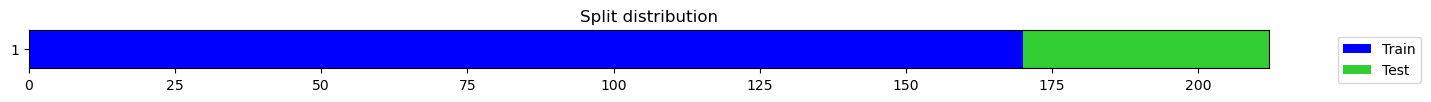

[5]  [ get_splits_ ] X~(212, 1, 17)
[5]  [ get_splits_ ] Train: 170 | Test 42
[5] [get_splits_ --> ]
[5]  [ fine_tune_mvp_single_ ] About to set callbacks
[5]  [ fine_tune_mvp_single_ ] About to set batch tfms
[5]  [ fine_tune_mvp_single_ ] Metrics: [<function MSELossFlat at 0x7f43d9eef1c0>, <function RMSELossFlat at 0x7f421a1dcf70>, <function L1LossFlat at 0x7f43d9eef250>, <function SMAPELossFlat at 0x7f421a1dd1b0>]
[5]  [ fine_tune_mvp_single_ ] Show plot


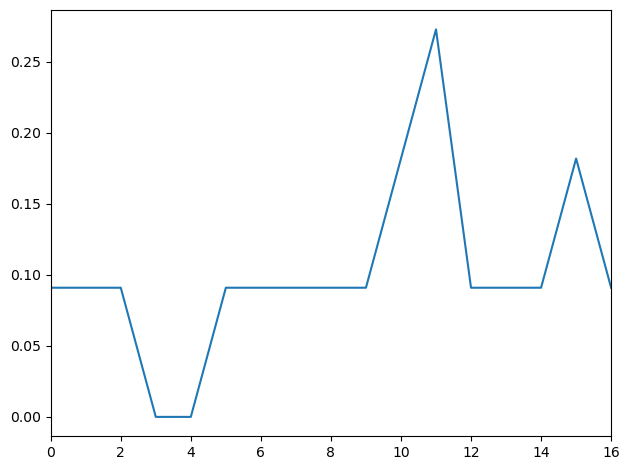

None

[5]  [ fine_tune_mvp_single_ ] Model Class <class 'fastai.learner.Learner'> | Type: <class 'fastai.learner.Learner'>
[5]  [ fine_tune_mvp_ ] Start timer
[5]  [ fine_tune_mvp_single_ ] Eval Pre | wlen 17 | Model: <class 'fastai.learner.Learner'> | <class 'fastai.learner.Learner'> 
[5]  [ fine_tune_mvp_single_ ] Model metrics: []


best epoch:   0  val_loss: 0.982668 - pretrained weights_path='models/encoder_MVP.pth'
not enough values to plot a chart
validate_with_metrics | <function MSELossFlat at 0x7f43d9eef1c0> | [0.9826680421829224]


best epoch:   0  val_loss: 0.970496 - pretrained weights_path='models/encoder_MVP.pth'
not enough values to plot a chart
validate_with_metrics | <function RMSELossFlat at 0x7f421a1dcf70> | [0.9704961180686951]


best epoch:   0  val_loss: 1.101355 - pretrained weights_path='models/encoder_MVP.pth'
not enough values to plot a chart
validate_with_metrics | <function L1LossFlat at 0x7f43d9eef250> | [1.1013548374176025]


best epoch:   0  val_loss: 0.881858 - pretrained weights_path='models/encoder_MVP.pth'
not enough values to plot a chart
validate_with_metrics | <function SMAPELossFlat at 0x7f421a1dd1b0> | [0.8818579316139221]
[5]  [ fine_tune_mvp_single_ ] results~4
[5]  [ fine_tune_mvp_single_ ] Eval results pre with custom metrics: {'mse': [0.9826680421829224], 'rmse': [0.9704961180686951], 'mae': [1.1013548374176025], 'smape': [0.8818579316139221]}
[5]  [ fine_tune_mvp_ ] End timer -->
[5]  [ fine_tune_mvp_ ] Start: 1736954987.4497979 | End: 1736954987.8005035 | Duration: 0.35 seconds
[5]  [ fine_tune_mvp_ ] Start timer
[5]  [ fine_tune_mvp_single_ ] Training the model | window size 17 | X ~ (212, 1, 17)


epoch,train_loss,valid_loss,time
0,1.023587,0.969206,00:00
1,0.855583,0.904339,00:00
2,0.785380,0.936390,00:00
3,0.701155,0.770649,00:00
4,0.642874,0.816484,00:00
5,0.598131,0.902101,00:00
6,0.543016,0.756815,00:00
7,0.529561,0.889574,00:00
8,0.508602,0.897982,00:00
9,0.494120,0.825404,00:00


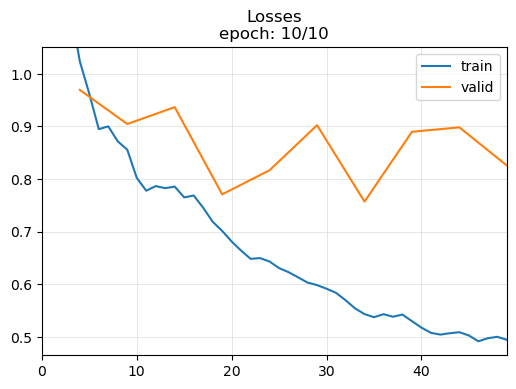


epochs: 10 best epoch:   6  val_loss: 0.756815 - pretrained weights_path='models/encoder_MVP.pth'



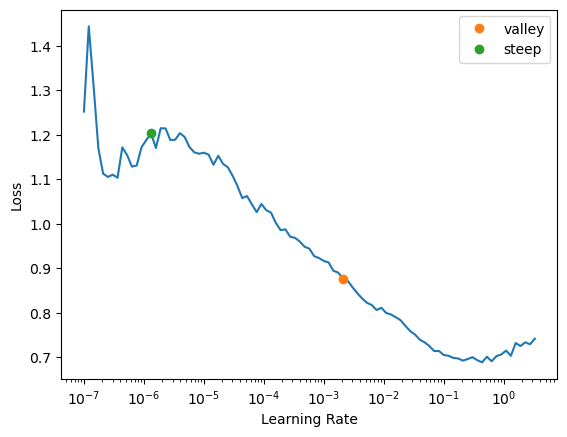

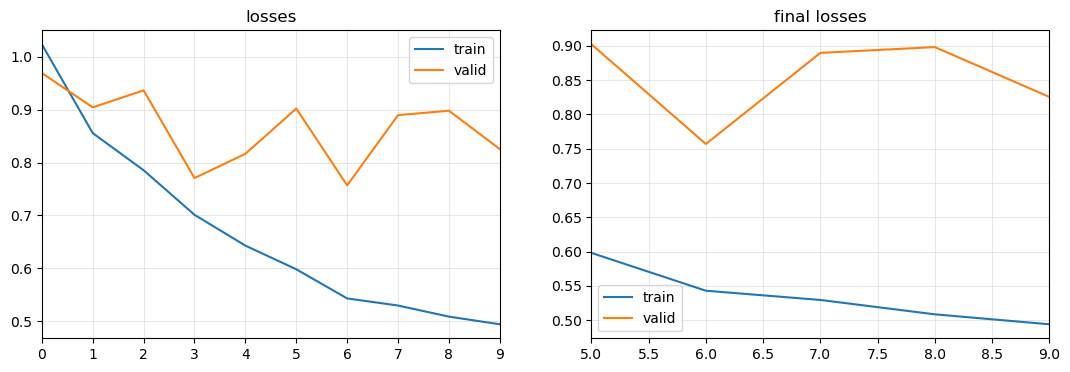

[5]  [ fine_tune_mvp_ ] End timer -->
[5]  [ fine_tune_mvp_ ] Start: 1736954987.8034515 | End: 1736954999.128898 | Duration: 11.33 seconds
[5]  [ fine_tune_mvp_ ] Start timer
[5]  [ fine_tune_mvp_single_ ] Eval Pre | wlen 17


not enough values to plot a chart
validate_with_metrics | <function MSELossFlat at 0x7f43d9eef1c0> | [0.7174256443977356]


not enough values to plot a chart
validate_with_metrics | <function RMSELossFlat at 0x7f421a1dcf70> | [1.0160249471664429]


not enough values to plot a chart
validate_with_metrics | <function L1LossFlat at 0x7f43d9eef250> | [0.98481285572052]


not enough values to plot a chart
validate_with_metrics | <function SMAPELossFlat at 0x7f421a1dd1b0> | [0.9168297648429871]
[5]  [ fine_tune_mvp_single_ ] Format results | results~4
[5]  [ fine_tune_mvp_single_ ] Eval results post with custom metrics: {'mse': [0.7174256443977356], 'rmse': [1.0160249471664429], 'mae': [0.98481285572052], 'smape': [0.9168297648429871]}
[5]  [ fine_tune_mvp_ ] End timer -->
[5]  [ fine_tune_mvp_ ] Start: 1736954999.1321633 | End: 1736954999.607527 | Duration: 0.48 seconds
[5] [fine_tune_mvp_single_ --> ]
t_shot_: 11.325446367263794
[5]  [ fine_tune_mvp_single_ ] Processing wlen 17
[5] [ --> fine_tune_mvp_single_ ]
[5] [ --> get_splits_ ]
[5]  [ get_splits_ ] len(X)=212
[5]  [ get_splits_ ] Online analysis


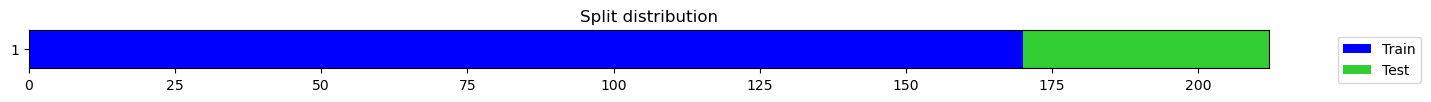

[5]  [ get_splits_ ] X~(212, 1, 18)
[5]  [ get_splits_ ] Train: 170 | Test 42
[5] [get_splits_ --> ]
[5]  [ fine_tune_mvp_single_ ] About to set callbacks
[5]  [ fine_tune_mvp_single_ ] About to set batch tfms
[5]  [ fine_tune_mvp_single_ ] Metrics: [<function MSELossFlat at 0x7f43d9eef1c0>, <function RMSELossFlat at 0x7f421a1dcf70>, <function L1LossFlat at 0x7f43d9eef250>, <function SMAPELossFlat at 0x7f421a1dd1b0>]
[5]  [ fine_tune_mvp_single_ ] Show plot


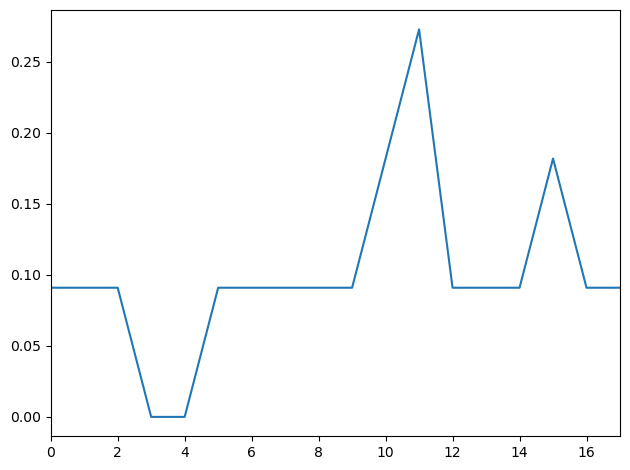

None

[5]  [ fine_tune_mvp_single_ ] Model Class <class 'fastai.learner.Learner'> | Type: <class 'fastai.learner.Learner'>
[5]  [ fine_tune_mvp_single_ ] Start timer
[5]  [ fine_tune_mvp_single_ ] Training the model | window size 18 | X ~ (212, 1, 18)


epoch,train_loss,valid_loss,time
0,0.905314,0.870172,00:00
1,0.847821,0.804661,00:00
2,0.766889,0.878292,00:00
3,0.714702,0.691302,00:00
4,0.680929,0.916803,00:00
5,0.651862,0.807826,00:00
6,0.608473,0.807861,00:00
7,0.584237,0.960648,00:00
8,0.567261,0.744303,00:00
9,0.547468,0.897521,00:00


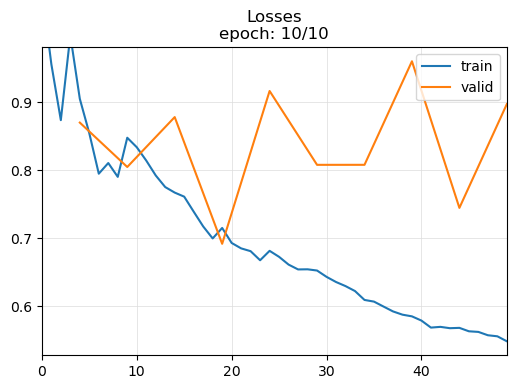


epochs: 10 best epoch:   3  val_loss: 0.691302 - pretrained weights_path='models/encoder_MVP.pth'



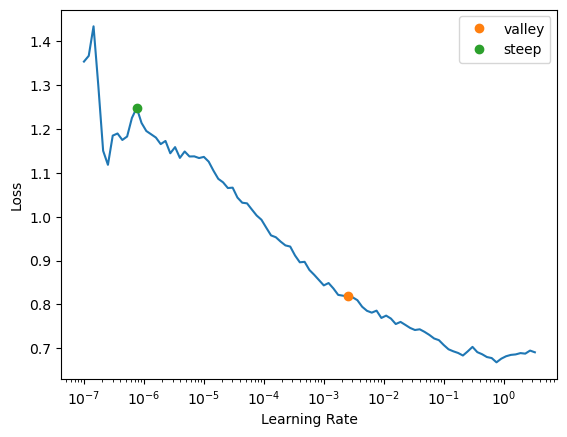

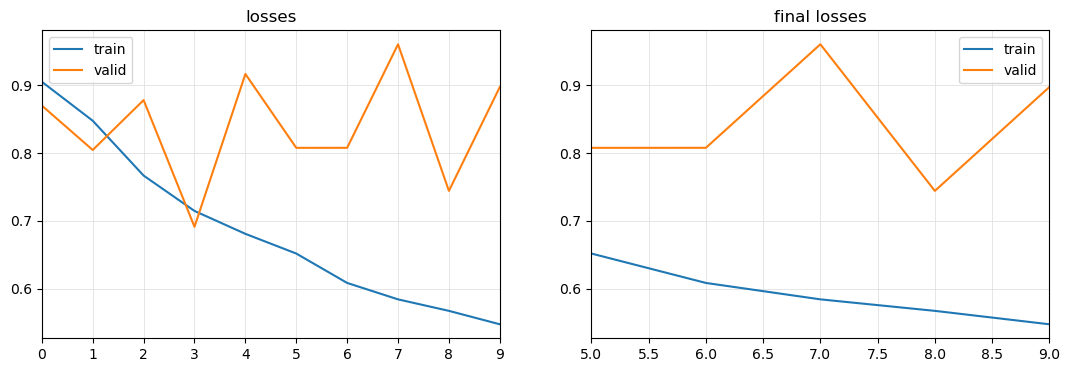

[5]  [ fine_tune_mvp_single_ ] End timer -->
[5]  [ fine_tune_mvp_single_ ] Start: 1736955000.305308 | End: 1736955011.9391062 | Duration: 11.63 seconds
[5]  [ fine_tune_mvp_single_ ] Start timer
[5]  [ fine_tune_mvp_single_ ] Eval Pre | wlen 18


not enough values to plot a chart
validate_with_metrics | <function MSELossFlat at 0x7f43d9eef1c0> | [1.055101752281189]


not enough values to plot a chart
validate_with_metrics | <function RMSELossFlat at 0x7f421a1dcf70> | [0.9721106290817261]


not enough values to plot a chart
validate_with_metrics | <function L1LossFlat at 0x7f43d9eef250> | [0.8713946342468262]


not enough values to plot a chart
validate_with_metrics | <function SMAPELossFlat at 0x7f421a1dd1b0> | [1.0831633806228638]
[5]  [ fine_tune_mvp_single_ ] Format results | results~4
[5]  [ fine_tune_mvp_single_ ] Eval results post with custom metrics: {'mse': [1.055101752281189], 'rmse': [0.9721106290817261], 'mae': [0.8713946342468262], 'smape': [1.0831633806228638]}
[5]  [ fine_tune_mvp_single_ ] End timer -->
[5]  [ fine_tune_mvp_single_ ] Start: 1736955011.9420898 | End: 1736955012.4499369 | Duration: 0.51 seconds
[5] [fine_tune_mvp_single_ --> ]
t_shot_: 11.633798122406006
[5]  [ fine_tune_mvp_single_ ] Processing wlen 17
[5] [ --> fine_tune_mvp_single_ ]
[5] [ --> get_splits_ ]
[5]  [ get_splits_ ] len(X)=215
[5]  [ get_splits_ ] Online analysis


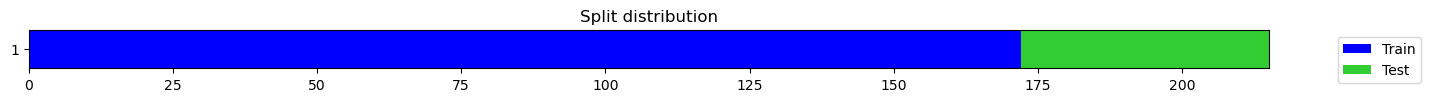

[5]  [ get_splits_ ] X~(215, 1, 12)
[5]  [ get_splits_ ] Train: 172 | Test 43
[5] [get_splits_ --> ]
[5]  [ fine_tune_mvp_single_ ] About to set callbacks
[5]  [ fine_tune_mvp_single_ ] About to set batch tfms
[5]  [ fine_tune_mvp_single_ ] Metrics: [<function MSELossFlat at 0x7f43d9eef1c0>, <function RMSELossFlat at 0x7f421a1dcf70>, <function L1LossFlat at 0x7f43d9eef250>, <function SMAPELossFlat at 0x7f421a1dd1b0>]
[5]  [ fine_tune_mvp_single_ ] Show plot


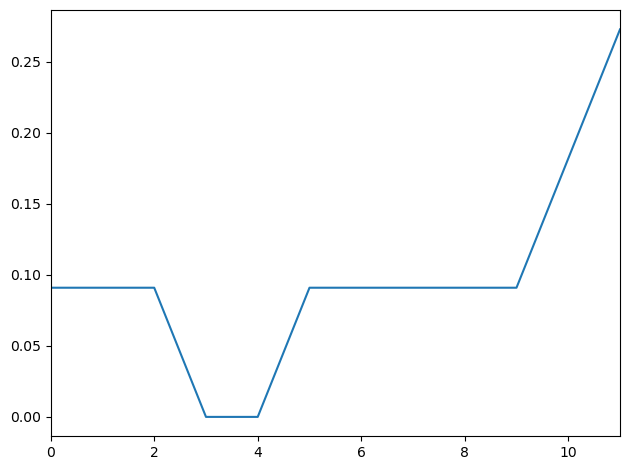

None

[5]  [ fine_tune_mvp_single_ ] Model Class <class 'fastai.learner.Learner'> | Type: <class 'fastai.learner.Learner'>
[5]  [ fine_tune_mvp_single_ ] Start timer
[5]  [ fine_tune_mvp_single_ ] Training the model | window size 12 | X ~ (215, 1, 12)


epoch,train_loss,valid_loss,time
0,1.065808,1.000470,00:00
1,0.950184,0.901941,00:00
2,0.813482,0.797394,00:00
3,0.714272,0.702076,00:00
4,0.649657,0.402573,00:00
5,0.597323,0.448761,00:00
6,0.577491,0.757709,00:00
7,0.544223,0.554995,00:00
8,0.512786,0.570693,00:00
9,0.487436,0.762956,00:00


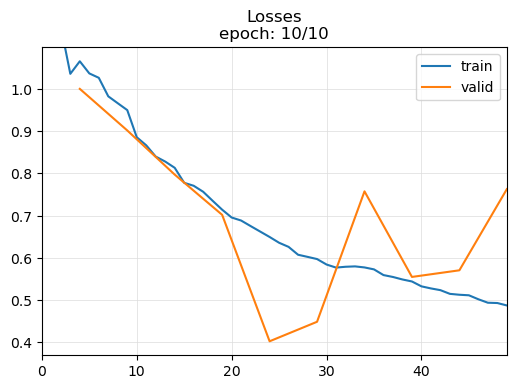


epochs: 10 best epoch:   4  val_loss: 0.402573 - pretrained weights_path='models/encoder_MVP.pth'



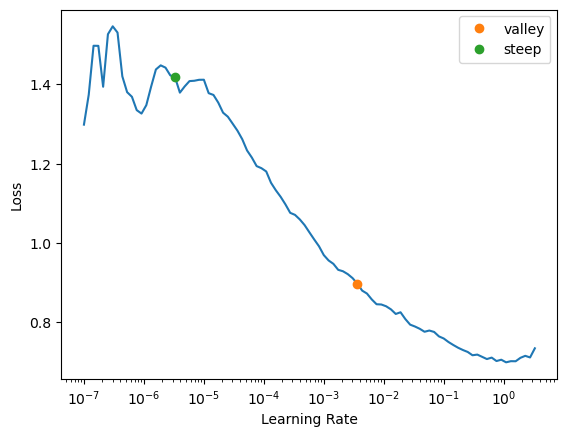

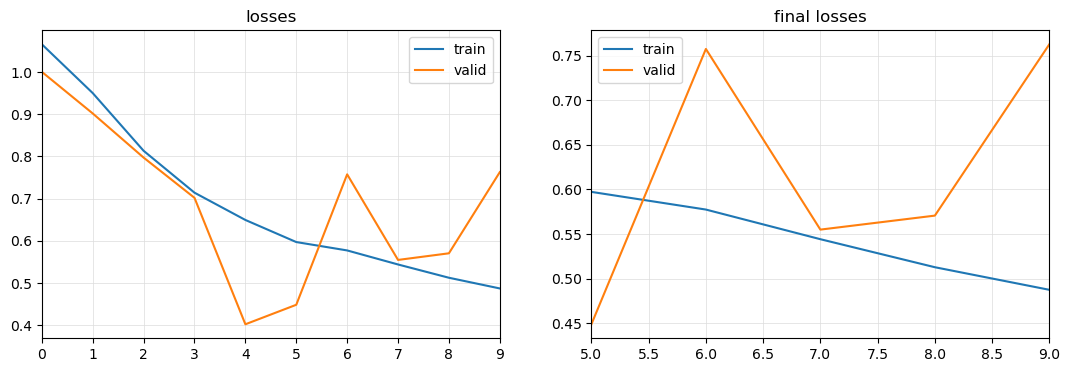

[5]  [ fine_tune_mvp_single_ ] End timer -->
[5]  [ fine_tune_mvp_single_ ] Start: 1736955013.1234643 | End: 1736955024.5887406 | Duration: 11.47 seconds
[5]  [ fine_tune_mvp_single_ ] Start timer
[5]  [ fine_tune_mvp_single_ ] Eval Pre | wlen 12


not enough values to plot a chart
validate_with_metrics | <function MSELossFlat at 0x7f43d9eef1c0> | [0.8191668391227722]


not enough values to plot a chart
validate_with_metrics | <function RMSELossFlat at 0x7f421a1dcf70> | [0.9435318112373352]


not enough values to plot a chart
validate_with_metrics | <function L1LossFlat at 0x7f43d9eef250> | [0.7592681050300598]


not enough values to plot a chart
validate_with_metrics | <function SMAPELossFlat at 0x7f421a1dd1b0> | [0.9176790118217468]
[5]  [ fine_tune_mvp_single_ ] Format results | results~4
[5]  [ fine_tune_mvp_single_ ] Eval results post with custom metrics: {'mse': [0.8191668391227722], 'rmse': [0.9435318112373352], 'mae': [0.7592681050300598], 'smape': [0.9176790118217468]}
[5]  [ fine_tune_mvp_single_ ] End timer -->
[5]  [ fine_tune_mvp_single_ ] Start: 1736955024.5917094 | End: 1736955024.9918807 | Duration: 0.40 seconds
[5] [fine_tune_mvp_single_ --> ]
t_shot_: 11.46527624130249
[5] [fine_tune_mvp_ --> ]


In [60]:
enc.mssg.verbose = 5
( 
    lossess, eval_results_pre, eval_results_post, 
    t_shots, t_shot, t_evals, t_eval, enc.model 
) = enc.fine_tune_(
    eval_pre              = True, 
    eval_post             = True, 
    shot                  = True, 
    time_flag             = True, 
    use_wandb             = enc_run.config['use_wandb'], 
    analysis_mode         = enc_run.config ['analysis_mode'], 
    norm_by_sample        = enc_run.config['norm_by_sample'], 
    norm_use_single_batch = enc_run.config['norm_use_single_batch'], 
    show_plot             = True
)

In [61]:
print(eval_results_pre)
print(eval_results_post)

{'mse': [0.9826680421829224], 'rmse': [0.9704961180686951], 'mae': [1.1013548374176025], 'smape': [0.8818579316139221]}
[{'mse': [0.7174256443977356], 'rmse': [1.0160249471664429], 'mae': [0.98481285572052], 'smape': [0.9168297648429871]}, {'mse': [1.055101752281189], 'rmse': [0.9721106290817261], 'mae': [0.8713946342468262], 'smape': [1.0831633806228638]}, {'mse': [0.8191668391227722], 'rmse': [0.9435318112373352], 'mae': [0.7592681050300598], 'smape': [0.9176790118217468]}]


In [50]:
metrics = [torch.nn.functional.mse_loss, rmse, mae, smape]
enc.model.metrics = metrics
enc.model.metrics

(#4) [<fastai.learner.AvgMetric object at 0x7f4364e29d20>,<fastai.learner.AvgMetric object at 0x7f4364e2b3d0>,<fastai.learner.AvgMetric object at 0x7f4364e2bd00>,<fastai.learner.AvgMetric object at 0x7f4364e2b5e0>]

In [51]:
enc.model.validate()

not enough values to plot a chart


(#1) [1.3531767129898071]

In [52]:
enc.model.metrics

(#0) []

In [53]:
#| export
if verbose > 0: print("Execution ended")
from dvats.imports import beep
beep(1)
beep(1)
beep(1)
beep(1)
beep(1)

In [54]:
#| hide
if reset_kernel:
    import os
    os._exit(00)